# Content <a id='content'></a>

[Introduction](#intro)

[Data overview and preprocessing](#prep)

[ML](#ml)

[Conclusions](#conclusions)

## Introduction <a id='intro'></a>

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning, and I was asked to evaluate that possibility.

1. Find customers who are similar to a given customer. This will help the company's agents with marketing.
2. Predict whether a new customer is likely to receive an insurance benefit. Compare the result of the prediction model with a dummy model?
3. Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
4. Protect clients' personal data without breaking the model from the previous task.

It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. Within the scope of the current project, we do not need to pick the best model, just prove that the algorithm works correctly.

To implement the work we will:

- Load the data.
- Check that the data is free of issues — there is no missing data, extreme values, and so on.
- Work through the tasks.
- Draw conclusions.

# Data overview and preprocessing <a id='prep'></a>

We got one file, `insurance_us.csv`, with the following data:

- Features: insured person's gender, age, salary, and number of family members.
- Target: number of insurance benefits received by an insured person over the last five years.

### Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import math

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from IPython.display import display

In [2]:
from typing import TypeVar
PandasDataFrame = TypeVar('pandas.core.frame.DataFrame')  # pd.DataFrame not supported

### File upload

We will use a load() function to avoid potential problems with the file pathes.

In [3]:
# function `load` for a csv load with try-except and a number of rows limit
def load(filename: str, sep: str = ',', nrow: int = None) -> PandasDataFrame:
    """
    i=In addition to the file name, the function takes nrows parameter
    for a particular number of rows to load. If None, then the file is loaded fully.
    """
    try:
        df_raw = pd.read_csv(filename, sep = sep, nrows = nrow)
    except:
        df_raw = pd.read_csv('/'+filename, sep = sep, nrows = nrow)
    return df_raw

In [4]:
# check the dataset data types and memory usage on the first 500 rows
data_raw = load('datasets/insurance_us.csv', nrow = 500)

In [5]:
data_raw.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              500 non-null    int64  
 1   Age                 500 non-null    float64
 2   Salary              500 non-null    float64
 3   Family members      500 non-null    int64  
 4   Insurance benefits  500 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 19.7 KB


The data types are correct, the column names can be fixed, the dataset does not look like the most memory-intensive for that number of variables, let's upload it alltogether:

In [6]:
data_raw = load('datasets/insurance_us.csv')

In [7]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


[Back to Content](#content)

### Basic preprocessing

First, let's fix the column names:

In [8]:
data_raw.columns = ['_'.join(x.lower().split()) for x in data_raw.columns]

We already know that we do not have missing values, let's see how the data looks like:

In [9]:
data_raw.head()

,gender,age,salary,family_members,insurance_benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Hm.. looks like there is enough opportunities for duplicates, though we cannot say whether they are true or by any mistake, let's check how meny similar entries we have:

In [10]:
data_raw.duplicated().sum()

153

Let's describe the variables and visualize the pair-wise distributions:

In [11]:
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0
age,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0
salary,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0
family_members,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0
insurance_benefits,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0


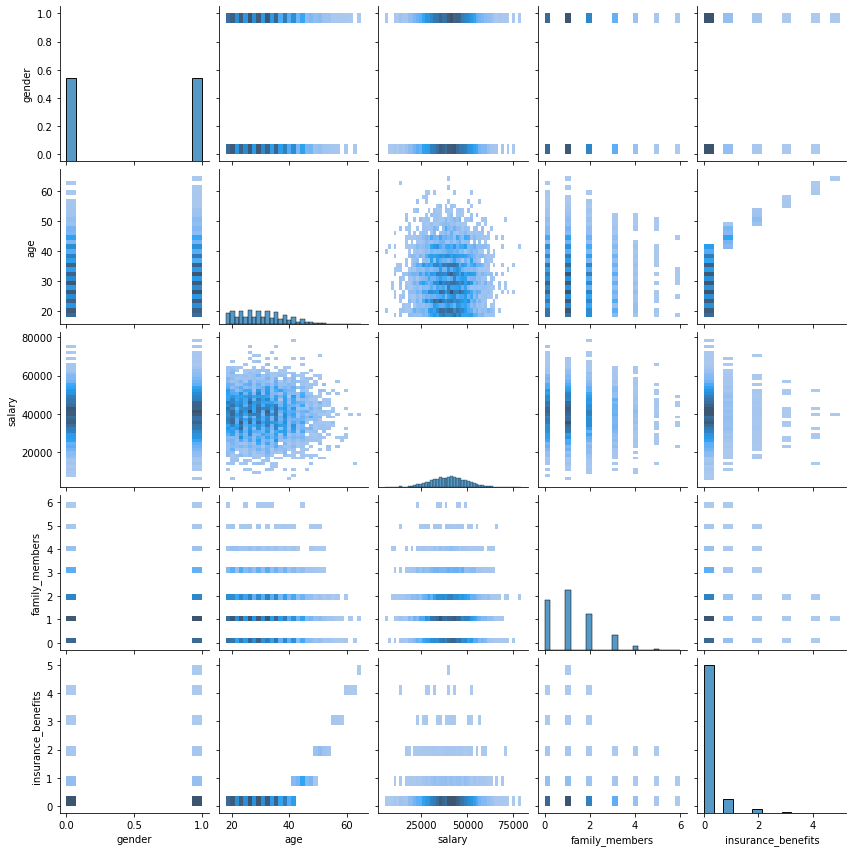

In [12]:
g = sns.pairplot(data_raw, kind='hist')
g.fig.set_size_inches(12, 12)

Looks like only customers aged 40+ receive insurance benefits. The sample includes almost equal number of men and women, only salary seems to be normally distributed. No outliers as well. Let's move on to the first task.

## Task 1. Find customers who are similar to a given customer. 

In ML terms, we need to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

To solve the problem, we will take the custome features and will write a function that returns k nearest neighbors for an $n^{th}$ object based on a pre-specified distance metric. To this end, we will employ the `sklearn.NearestNeighbors` learner and find k-nearest neighbors to the point using the `kneighbors` method of the [class](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html).

In [13]:
feature_names = ['gender', 'age', 'salary', 'family_members']

In [14]:
def get_knn(df: PandasDataFrame, n: int, k: int, metric: str) -> PandasDataFrame:
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    neighbors =  sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric=metric)
    neighbors.fit(df[feature_names].values)
    neighbors_distances, neighbors_indices = neighbors.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_out = pd.concat([
        df.iloc[neighbors_indices[0]], 
        pd.DataFrame(neighbors_distances.T, index=neighbors_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_out

We will apply the function above to four cases and study the differences:

1. raw data
2. scaled data
3. euclidian distances
4. manhattan distances

For scaling, we will employ the `MaxAbsScaler` scaler.

In [15]:
data_scaled = data_raw.copy()
data_scaled.loc[:, feature_names] = sklearn.preprocessing.MaxAbsScaler().fit_transform(
    data_scaled[feature_names].to_numpy())

Let's take a look how the `data_scaled` dataframe looks like (Note: we did not scale the target variable, `insurance_benefits`:

In [16]:
data_scaled.head()

,gender,age,salary,family_members,insurance_benefits
0,1.0,0.630769,0.627848,0.166667,0
1,0.0,0.707692,0.481013,0.166667,1
2,0.0,0.446154,0.265823,0.000000,0
3,0.0,0.323077,0.527848,0.333333,0
4,1.0,0.430769,0.330380,0.000000,0


OK, let's consider the four cases:

In [17]:
# unscaled data / euclidean distance
get_knn(data_raw[feature_names], 0, 10, 'euclidean')

,gender,age,salary,family_members,distance
0,1,41.0,49600.0,1,0.000000
2022,1,41.0,49600.0,0,1.000000
1225,0,42.0,49600.0,0,1.732051
4031,1,44.0,49600.0,2,3.162278
3424,0,38.0,49600.0,0,3.316625
815,1,37.0,49600.0,2,4.123106
4661,0,45.0,49600.0,0,4.242641
2125,0,37.0,49600.0,2,4.242641
3900,1,36.0,49600.0,0,5.099020
2349,1,46.0,49600.0,2,5.099020


In [18]:
# scaled data / euclidean distance
get_knn(data_scaled[feature_names], 0, 10, 'euclidean')

,gender,age,salary,family_members,distance
0,1.0,0.630769,0.627848,0.166667,0.000000
2689,1.0,0.630769,0.634177,0.166667,0.006329
133,1.0,0.615385,0.636709,0.166667,0.017754
4869,1.0,0.646154,0.637975,0.166667,0.018418
3275,1.0,0.646154,0.651899,0.166667,0.028550
1567,1.0,0.615385,0.602532,0.166667,0.029624
3365,1.0,0.630769,0.596203,0.166667,0.031646
2103,1.0,0.630769,0.596203,0.166667,0.031646
124,1.0,0.661538,0.635443,0.166667,0.031693
3636,1.0,0.615385,0.600000,0.166667,0.031815


We can observe that the resulting dataframe differs significantly: unlike in case of the unscaled data, where customers with exactly the same income are chosen (the variable with the highst level of values), on scaled data customers from the same gender and with similar number of family members are chosen, while the income level is also similar. Let's check the Manhattan distance:

In [19]:
# unscaled data / manhattan distance
get_knn(data_raw[feature_names], 0, 10, 'manhattan')

,gender,age,salary,family_members,distance
0,1,41.0,49600.0,1,0.0
2022,1,41.0,49600.0,0,1.0
1225,0,42.0,49600.0,0,3.0
4031,1,44.0,49600.0,2,4.0
3424,0,38.0,49600.0,0,5.0
815,1,37.0,49600.0,2,5.0
4661,0,45.0,49600.0,0,6.0
2349,1,46.0,49600.0,2,6.0
2125,0,37.0,49600.0,2,6.0
3900,1,36.0,49600.0,0,6.0


In [20]:
# scaled data / manhattan distance
get_knn(data_scaled[feature_names], 0, 10, 'manhattan')

,gender,age,salary,family_members,distance
0,1.0,0.630769,0.627848,0.166667,0.000000
2689,1.0,0.630769,0.634177,0.166667,0.006329
133,1.0,0.615385,0.636709,0.166667,0.024245
4869,1.0,0.646154,0.637975,0.166667,0.025511
3365,1.0,0.630769,0.596203,0.166667,0.031646
2103,1.0,0.630769,0.596203,0.166667,0.031646
124,1.0,0.661538,0.635443,0.166667,0.038364
4305,1.0,0.630769,0.588608,0.166667,0.039241
3275,1.0,0.646154,0.651899,0.166667,0.039435
1567,1.0,0.615385,0.602532,0.166667,0.040701


Similar effect can be observet for the Manhattan distance, while the unscaled results are identical for the two distance metrics and the scaled results are identical (the order can differ and the distance values differ, as can be expected). All in all, these examples demonstrate the distance-based methods are affected by features not being scaled.

[Back to Content](#content)

## Task 2. Predict whether a new customer is likely to receive an insurance benefit.

In ML terms, we need to build a classification model. We will build a KNN-based classifier and measure its quality with the F1 metric for k equal 1 to 10 for both the raw data and the scaled one. Thus, we will see how k may influece the evaluation metric and how scaling the data makes affects the results. Before we proceed, we will build a dummy model which is supposed to be just random for this case: it should return `1` with some probability. Let's test the model with four probability values: 0, some probability of paying any insurance benefit, 0.5, 1. We will split the data in 70-to-30 ration.

Let's create the target variable:

In [21]:
data_raw['benefit_received'] = np.where(data_raw['insurance_benefits']>0,1,0)

Let's check for the class imbalance with value_counts():

In [22]:
data_raw['benefit_received'].value_counts(normalize=True)

0    0.8872
1    0.1128
Name: benefit_received, dtype: float64

Thus, only 11% of the customera recieve any benefits and we should account for a relatively high imbalance.

Let's split the data. We should preserve the ratio of the customers who received benefits while splitting:

In [23]:
# split data into train and test sets in 70-to-30 ratio
train, test = train_test_split(data_raw, test_size=0.3, stratify=data_raw['benefit_received'], random_state=12345)

X_train = train[feature_names]
X_test = test[feature_names]
y_train = train['benefit_received']
y_test = test['benefit_received']

Now, let's establish a random classifier. to this end, we will employ the [`DummyClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). The specific behavior of the classifier is selected with the strategy parameter, and in our case we should put it as `startified`.

In [24]:
from sklearn.dummy import DummyClassifier

In [25]:
dummy_clf = DummyClassifier(strategy="stratified", random_state = 54321) # use random_state to make the results comparable
dummy_clf.fit(X_train, y_train)

dummy_clf.score(X_test, y_test)

0.7913333333333333

The default score metric for the `DummyClassifier` is accuracy; however, we were requested to apply the F1-score to measure the quality of our models. Let's construct the evaluation function:

In [26]:
def f1_score(y_true: np.array, y_pred: np.array) -> None:
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')

Let's consider the `DummyClassifier` predictions:

In [27]:
dummy_predictions = dummy_clf.predict(X_test)

Now, let's apply the F1-score:

In [28]:
f1_score(y_test, dummy_predictions)

F1: 0.09


The F1-score of a dummy model on unscaled data equal 0.09. Let's check the scaled data.

In [29]:
scaler =  sklearn.preprocessing.MaxAbsScaler()

In [30]:
pipe = Pipeline([('scaler', scaler), ('dummy_model', dummy_clf)])

In [31]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('dummy_model',
                 DummyClassifier(random_state=54321, strategy='stratified'))])

In [32]:
pipe.predict(X_test)

array([1, 0, 0, ..., 1, 0, 0])

In [33]:
dummy_predictions_scaled = pipe.predict(X_test)

In [34]:
f1_score(y_test, dummy_predictions_scaled)

F1: 0.09


The same result on the scaled data.

Based on this reference point, let's build a more universal random model, which will return `1` with some probability, not just by a predefined strategy. To this end. we will employ the `numpy.random.Generator.binomial` method.

In [35]:
def random_predict(probability: float, array_size: int, seed: int = 12345):
    """Returns an array of ones from binomial(1,p) destribution."""
    rng = np.random.default_rng(seed=seed) # use the numpy random generator 
    return rng.binomial(n=1, p=prob, size=array_size) # n trials, with p - probability of success, and size as output shape

In [36]:
for prob in [0, data_raw['benefit_received'].sum() / len(data_raw), 0.5, 1]:
    random_predictions = random_predict(prob, y_test.shape[0]) 
    print(f'Probability of True: {prob:.2f}')
    f1_score(y_test, random_predictions)  # includes printing

Probability of True: 0.00
F1: 0.00
Probability of True: 0.11
F1: 0.09
Probability of True: 0.50
F1: 0.17
Probability of True: 1.00
F1: 0.20


Now, let's  build a KNN-based classifier and measure its quality with the F1 metric for k equal 1 to 10 for both the original data and the scaled one. We will set the `weights` parameter to `distance` to make closer neighbors of a query point to have a greater influence than neighbors which are further away.

In [37]:
knn = sklearn.neighbors.KNeighborsClassifier(weights = 'distance')  # we will use the default value of the neighbors, 5.

Unscaled data:

In [38]:
knn.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [39]:
knn_predictions_unscaled = knn.predict(X_test)

In [40]:
f1_score(y_test, knn_predictions_unscaled)

F1: 0.48


Scaled data:

In [41]:
pipe = Pipeline([('scaler', scaler), ('model', knn)])

In [42]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('model', KNeighborsClassifier(weights='distance'))])

In [43]:
knn_predictions = pipe.predict(X_test)

In [44]:
f1_score(y_test, knn_predictions)

F1: 0.93


The KNN-model resulted in F1-score of 0.48 on unscaled data and 0.93 on the scaled data; thus, the scaled data has an obvious advantage. Let's run the model for k equal 1 to 10 neighbors:

In [45]:
for k in range(1,11):
    model = knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors = k, weights = 'distance')
    pipe = Pipeline([('scaler', scaler), ('model', model)])
    pipe.fit(X_train, y_train)
    model_predictions = pipe.predict(X_test)
    print(f"For k={k}:")
    f1_score(y_test, model_predictions)

For k=1:
F1: 0.96
For k=2:
F1: 0.96
For k=3:
F1: 0.95
For k=4:
F1: 0.95
For k=5:
F1: 0.93
For k=6:
F1: 0.95
For k=7:
F1: 0.93
For k=8:
F1: 0.93
For k=9:
F1: 0.94
For k=10:
F1: 0.94


The highest F1-score is observed for `k=1`.

To sum up:

1. We established a dummy model, which scored maximum 0.2 for the F1-score when assigning success in 100% of cases.
2. As expected, the KNN model performed much better for the scaled data.
3. When running for the n_neighbors equal 1 to 10, the best score (0.96) was achieved with k=1.

## Task 3. Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.

In this part, we will build a RMSE model with `insurance_benefits` as the target. We will run it for the raw and the scale datasets as well, to show the difference and estimate the quality with RMSE and R2, as well.

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

In the linear algebra terms, the task of linear regression can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the MSE (L2-distance) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Let's define the Linear Regression class:

In [46]:
class MyLinearRegression:
    def __init__(self):
        
        self.weights = None
        
    def fit(self, train_features: np.array, train_target: np.array) -> np.array:
        
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        self.weights = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        
        return self.weights

    def predict(self, test_features: np.array) -> np.array:
        
        X = np.append(np.ones([len(test_features), 1]), test_features, axis=1)
        y_pred = X.dot(self.weights)
        
        return y_pred

Now, let's build the regression quality estimator:

In [47]:
def lr_scores(y_true: np.array, y_pred: np.array) -> None:
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}') 

Now we can run the regression model. First, let' check the original data (we have to split the data again):

In [48]:
data_raw.drop('benefit_received', axis = 1, inplace = True)

In [49]:
data_raw.head(1)

,gender,age,salary,family_members,insurance_benefits
0,1,41.0,49600.0,1,0


We will try to preserve the distribution by the `family_members` variable:

In [50]:
# split data into train and test sets in 70-to-30 ratio
train, test = train_test_split(data_raw, test_size=0.3, stratify=data_raw['family_members'], random_state=12345)

X_train = train[feature_names]
X_test = test[feature_names]
y_train = train['insurance_benefits']
y_test = test['insurance_benefits']

In [51]:
lr = MyLinearRegression()
lr.fit(X_train.values, y_train.values)
print(lr.weights)

[-9.71188809e-01 -2.18976997e-03  3.64262434e-02  3.99609435e-07
 -1.77263187e-02]


In [52]:
predictions = lr.predict(X_test)

In [53]:
lr_scores(y_test,predictions)

RMSE: 0.34
R2: 0.64


Now, let's see how the Linear Regression for the scaled data looks like:

In [54]:
pipe = Pipeline([('scaler', scaler), ('linear', lr)])

In [55]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('linear',
                 <__main__.MyLinearRegression object at 0x00000262B1A7DFA0>)])

In [56]:
print(pipe['linear'].weights)

[-9.71188809e-01 -2.18976997e-03  2.36770582e+00  2.98907858e-02
 -1.06357912e-01]


In [57]:
predictions = pipe.predict(X_test)

In [58]:
lr_scores(y_test,predictions)

RMSE: 0.34
R2: 0.64


As we can see, the only difference is in the feature weights themselves, since they adapt to the scaled feature values, which makes them a bit more readable.

To sum up:

1. We established a custom Linear model and scoring function, which uses two metrics, RMSE and R2.
2. We run the model for two cases, raw and scaled data.
3. As expected, scaling of the features results in different magnitude of the linear regression coefficients.

Note: scaling can make a difference for linear regression in different circumstances, for example, if we use L1/L2 regularization or trained the model using stochastic gradient descent.

[Back to Content](#content)

## Task 4. Protect clients' personal data without breaking the model from the previous task.

We will obfuscate data by multiplying the numerical features by an invertible matrix $P$:

$$
X' = X \times P
$$

Note: the invertible property is important here, to be able to recover the original data.

Let's generate the random matrix $P$:

In [59]:
X = data_raw[feature_names]

In [60]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Now, let's check that the matrix is invertible.

In [61]:
np.matmul(P, np.linalg.inv(P))

array([[ 1.00000000e+00, -1.14337421e-16, -7.58122972e-17,
         1.89091165e-17],
       [ 8.51680974e-17,  1.00000000e+00, -7.10568689e-17,
         1.47898982e-16],
       [-4.34608597e-19, -8.01461326e-17,  1.00000000e+00,
         1.93902515e-17],
       [ 1.20295083e-16, -3.05630046e-16, -1.91527957e-16,
         1.00000000e+00]])

Let's get transformed data:

In [62]:
X_transformed = np.matmul(X,P)

Let's see the recovered data:

In [63]:
X_recovered = X_transformed.dot(np.linalg.inv(P))

Now, we will print out examples of the three cases (for more readability we will cast all the values into integers):

In [64]:
X.head()

,gender,age,salary,family_members
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0


In [65]:
X_transformed.head()

,0,1,2,3
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


In [66]:
X_recovered.head()

,0,1,2,3
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,6.665554e-13,46.0,38000.0,1.000000e+00
2,3.847477e-13,29.0,21000.0,1.419408e-12
3,-2.698751e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,4.917514e-13


Let's see how it looks when we cast the values into integers (rounding to the lower integer):

In [67]:
X_recovered.head().astype('int')

,0,1,2,3
0,0,40,49600,1
1,0,46,37999,1
2,0,28,20999,0
3,0,20,41699,2
4,1,27,26100,0


The matrix is arranged a bit different and all the values turn to be floats. The values of the same data point differ due to the way floating point numbers work.

[Back to Content](#content)

Let's show that this transformation does not affect the model. To this end, we will use some propertices of the matrices:

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>

Thus, now, instead $X$ we have $X \times P$; thus, the linear regression weights have a modified formula:

$w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y$

Let's expand the parentheses:

$w_p = [(XP)^T XP]^{-1}(XP)^Ty \qquad \qquad (1)$

$w_p = [P^T X^T XP]^{-1} P^T X^T y\qquad \qquad(2)$

$w_p = (P^T (X^T X) P)^{-1} P^T X^T y \qquad \qquad(3)$

$w_p = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y \qquad \qquad(4)$

$w_p = P^{-1} (X^T X)^{-1} I X^T y \qquad \qquad(5)$

$w_p = P^{-1} (X^T X)^{-1} X^T y \qquad \qquad(6)$

Now we see, that the modified weights are calculated through the inverted matrix $P$:

$w_p = P^{-1} w \qquad \qquad(7)$

Now, let's take a look at the predictions:

$a = XPP^{-1}w\qquad(1)$

$a = XPP^{-1}w\qquad(2)$

We can see that this expression is similar to $a=Xw$, when we substitute $w_p=P^{-1}w$ and $X'=XP$.

$a'=X'w=XIw=Xw=a \qquad(3),$

Thus, the RMSE will be the same for the transformed matrix as for the raw matrix; same the quality of the linear regression. Let's show that:

In [68]:
# split data into train and test sets in 70-to-30 ratio
X_train, X_test, y_train, y_test = train_test_split(X_transformed, data_raw['insurance_benefits'],
                                                       test_size=0.3, random_state=12345)

In [69]:
lr = MyLinearRegression()

In [70]:
lr.fit(X_train, y_train)

array([-0.94353901, -0.05791721, -0.01546574,  0.09871899, -0.02397537])

In [71]:
predictions = lr.predict(X_test)

In [72]:
lr_scores(y_test, predictions)

RMSE: 0.34
R2: 0.66


The linear regression weights vary and the scores obtained are the same result, as expected.

To sum up:

1. We established why it is possible to mask the data by multiplying the numerical features by an invertible matrix.
2. We showed why the invertability property is important.
3. We run the regression on transformed data, and received a model of the same quality as expected.

## Conclusions <a id='conclusions'></a>

1. We uploaded the data and performed basic pre-processing.
2. We established a procedure to find customers who are similar to a given customer, using two distance metrics, Euclidian and Manhatten; we showed that scaling significantly affects the neighbor search.
3. We established a classification model to predict whether a new customer is likely to receive an insurance benefit:

    - A baseline dummy model scored maximum 0.2 for the F1-score when assigning success in 100% of cases.
    - As expected, the KNN model performed much better for the scaled data.
    - When running for the n_neighbors equal 1 to 10, the best score (0.96) was achieved with k=1.

4. We established a linear model to predict the number of insurance benefits a new customer is likely to receive using a linear regression model.

    - We used a scoring function, which uses two metrics, RMSE and R2.
    - We run the model for two cases, raw and scaled data.
    - As expected, scaling of the features results in different magnitude of the linear regression coefficients.

5. Finally, we showed how the raw customer data can be masked by multiplying on an invertible matrix.

    - We established why it is possible to mask the data by multiplying the numerical features by an invertible matrix.
    - We showed why the invertability property is important.
    - We run the regression on transformed data, and received a model of the same quality as expected.

[Back to Content](#content)